In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


## Movie Genre Classification
In this notebook a machine learning model is built that can predict the genre of a movie based on its description summary. TF-IDF or word embeddings with classifiers such as Naive Bayes, Logistic Regression, Support Vector Machines are implemented.

## Data loading & Framing

In [2]:
train_path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt"
df = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
df

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [3]:
test_path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt"
df_test = pd.read_csv(test_path, sep=':::', names=[ 'Title', 'Description'], engine='python')
df_test

,Title,Description
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),Before he was known internationally as a mart...
...,...,...
54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da..."
54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...
54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...
54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard..."



## Information about  Training dataset

In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [5]:
df['Genre'].value_counts()

Genre
drama           13613
documentary     13096
comedy           7447
short            5073
horror           2204
thriller         1591
action           1315
western          1032
reality-tv        884
family            784
adventure         775
music             731
romance           672
sci-fi            647
adult             590
crime             505
animation         498
sport             432
talk-show         391
fantasy           323
mystery           319
musical           277
biography         265
history           243
game-show         194
news              181
war               132
Name: count, dtype: int64

## EDA

In [ ]:
import seaborn as sns

In [7]:
import matplotlib.pyplot as plt

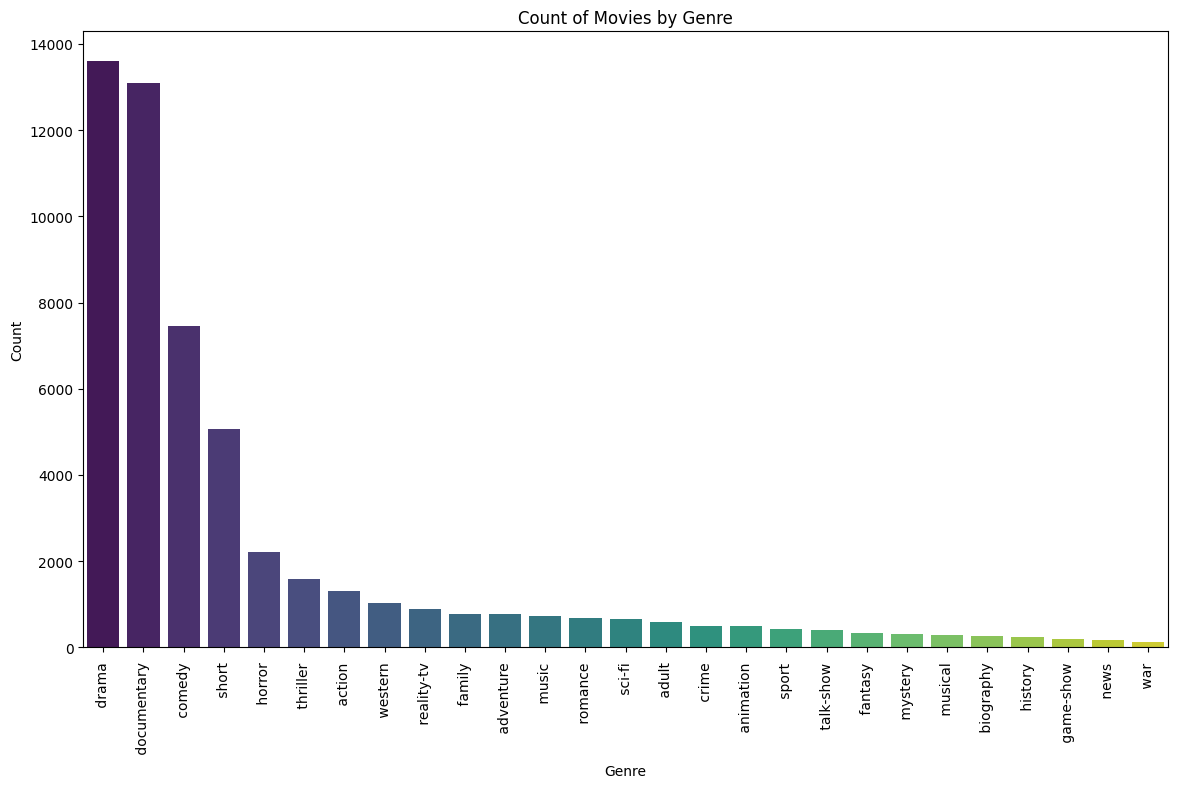

In [8]:
# Create the count plot
plt.figure(figsize=(14, 8))
count_plot = sns.countplot(data=df, x='Genre', palette='viridis', order=df['Genre'].value_counts().index)

# Rotate x-axis labels for better readability
count_plot.set_xticklabels(count_plot.get_xticklabels(), rotation=90)

# Add title and labels
plt.title('Count of Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Count')

# Display the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


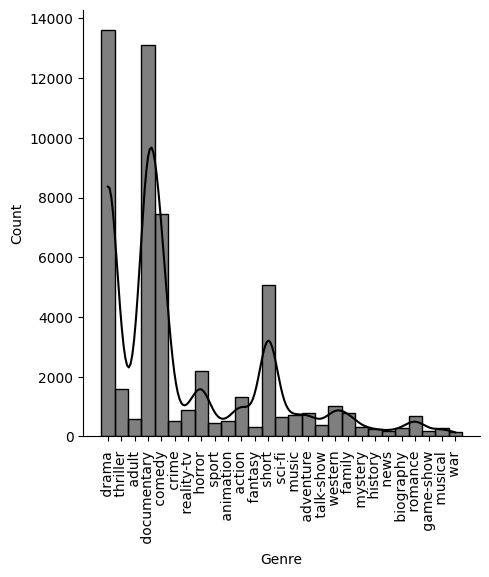

In [10]:
sns.displot(df.Genre,kde=True, color='black')
plt.xticks(rotation=90);

In [11]:
df.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Nature's Fury: Storm of the Century (2006),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [12]:
df_test.describe()

,Title,Description
count,54200,54200
unique,54200,54072
top,Curitiba Zero Grau (2010),Grammy - music award of the American academy ...
freq,1,10


## Preprocessing

In [13]:
import nltk

In [14]:
!pip install nltk

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
df['num_char_D'] = df['Description'].apply(len)

In [17]:

df['num_char_T'] = df['Title'].apply(len)

In [18]:
df.head()

,Title,Genre,Description,num_char_D,num_char_T
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,30
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,14
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,34
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,23
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,24


In [19]:
df_test['num_char_D'] = df_test['Description'].apply(len)

In [20]:
df_test['num_char_T'] = df_test['Title'].apply(len)

In [21]:

df_test.head()

,Title,Description,num_char_D,num_char_T
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",510,22
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",674,26
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,590,29
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",681,24
5,Er nu zhai (1955),Before he was known internationally as a mart...,814,19


In [22]:
# num of words
df['num_words_D'] = df['Description'].apply(lambda x:len(nltk.word_tokenize(x)))

In [23]:
# num of words
df['num_words_T'] = df['Title'].apply(lambda x:len(nltk.word_tokenize(x)))

In [24]:
df.head()

,Title,Genre,Description,num_char_D,num_char_T,num_words_D,num_words_T
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,30,105,8
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,14,34,4
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,34,129,8
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,23,216,6
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,24,115,5


In [25]:
# num of words
df_test['num_words_D'] = df['Description'].apply(lambda x:len(nltk.word_tokenize(x)))

In [26]:
# num of words
df_test['num_words_T'] = df['Title'].apply(lambda x:len(nltk.word_tokenize(x)))

In [27]:
df_test.head()

,Title,Description,num_char_D,num_char_T,num_words_D,num_words_T
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",510,22,105,8
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",674,26,34,4
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,590,29,129,8
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",681,24,216,6
5,Er nu zhai (1955),Before he was known internationally as a mart...,814,19,115,5


In [28]:
df['num_sen_D'] = df['Description'].apply(lambda x:len(nltk.sent_tokenize(x)))


In [29]:
df_test['num_sen_D'] = df_test['Description'].apply(lambda x:len(nltk.sent_tokenize(x)))


In [30]:
df.head()

,Title,Genre,Description,num_char_D,num_char_T,num_words_D,num_words_T,num_sen_D
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,30,105,8,4
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,14,34,4,2
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,34,129,8,7
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,23,216,6,9
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,24,115,5,3


In [31]:
df_test.head()

,Title,Description,num_char_D,num_char_T,num_words_D,num_words_T,num_sen_D
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",510,22,105,8,8
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",674,26,34,4,5
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,590,29,129,8,3
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",681,24,216,6,7
5,Er nu zhai (1955),Before he was known internationally as a mart...,814,19,115,5,6


dropping the columns since the correlation is high

In [32]:
df_test = df.drop(columns=['num_words_D','num_words_T','num_sen_D'])


In [33]:

from collections import Counter


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

# Ensure the necessary NLTK resources are downloaded

nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
# Convert the 'description' column to lowercase and remove punctuation
df['Description'] = df['Description'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
df['Title'] = df['Title'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
df_test['Description'] = df_test['Description'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
df_test['Title'] = df_test['Title'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
# Basic text preprocessing function
def preprocess_text(text):
    # Tokenize text
    words = word_tokenize(text)
    
    # Remove non-alphanumeric characters
    words = [word for word in words if word.isalnum()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words] 
    
    # Stemming
    ps = PorterStemmer()
    words = [ps.stem(word) for word in words]
    
    return words

# Apply the preprocessing function to the 'description' column
df['processed_description'] = df['Description'].apply(preprocess_text)
df['processed_Title'] = df['Title'].apply(preprocess_text)
df_test['processed_Title'] = df_test['Title'].apply(preprocess_text)
df_test['processed_description'] = df_test['Description'].apply(preprocess_text)

In [35]:
df.head()

,Title,Genre,Description,num_char_D,num_char_T,num_words_D,num_words_T,num_sen_D,processed_description,processed_Title
1,oscar et la dame rose 2009,drama,listening in to a conversation between his do...,546,30,105,8,4,"[listen, convers, doctor, parent, 10yearold, o...","[oscar, et, la, dame, rose, 2009]"
2,cupid 1997,thriller,a brother and sister with a past incestuous r...,184,14,34,4,2,"[brother, sister, past, incestu, relationship,...","[cupid, 1997]"
3,young wild and wonderful 1980,adult,as the bus empties the students for their fie...,650,34,129,8,7,"[bu, empti, student, field, trip, museum, natu...","[young, wild, wonder, 1980]"
4,the secret sin 1915,drama,to help their unemployed father make ends mee...,1082,23,216,6,9,"[help, unemploy, father, make, end, meet, edit...","[secret, sin, 1915]"
5,the unrecovered 2007,drama,the films title refers not only to the unreco...,625,24,115,5,3,"[film, titl, refer, unrecov, bodi, ground, zer...","[unrecov, 2007]"


In [36]:
df_test.head()

,Title,Genre,Description,num_char_D,num_char_T,processed_Title,processed_description
1,oscar et la dame rose 2009,drama,listening in to a conversation between his do...,546,30,"[oscar, et, la, dame, rose, 2009]","[listen, convers, doctor, parent, 10yearold, o..."
2,cupid 1997,thriller,a brother and sister with a past incestuous r...,184,14,"[cupid, 1997]","[brother, sister, past, incestu, relationship,..."
3,young wild and wonderful 1980,adult,as the bus empties the students for their fie...,650,34,"[young, wild, wonder, 1980]","[bu, empti, student, field, trip, museum, natu..."
4,the secret sin 1915,drama,to help their unemployed father make ends mee...,1082,23,"[secret, sin, 1915]","[help, unemploy, father, make, end, meet, edit..."
5,the unrecovered 2007,drama,the films title refers not only to the unreco...,625,24,"[unrecov, 2007]","[film, titl, refer, unrecov, bodi, ground, zer..."


In [37]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the "Genre" column
df['Genre_encoded'] = label_encoder.fit_transform(df['Genre'])

# Display the first few rows
df.head()


,Title,Genre,Description,num_char_D,num_char_T,num_words_D,num_words_T,num_sen_D,processed_description,processed_Title,Genre_encoded
1,oscar et la dame rose 2009,drama,listening in to a conversation between his do...,546,30,105,8,4,"[listen, convers, doctor, parent, 10yearold, o...","[oscar, et, la, dame, rose, 2009]",8
2,cupid 1997,thriller,a brother and sister with a past incestuous r...,184,14,34,4,2,"[brother, sister, past, incestu, relationship,...","[cupid, 1997]",24
3,young wild and wonderful 1980,adult,as the bus empties the students for their fie...,650,34,129,8,7,"[bu, empti, student, field, trip, museum, natu...","[young, wild, wonder, 1980]",1
4,the secret sin 1915,drama,to help their unemployed father make ends mee...,1082,23,216,6,9,"[help, unemploy, father, make, end, meet, edit...","[secret, sin, 1915]",8
5,the unrecovered 2007,drama,the films title refers not only to the unreco...,625,24,115,5,3,"[film, titl, refer, unrecov, bodi, ground, zer...","[unrecov, 2007]",8


In [38]:
df = df.drop(columns=['Title','Genre','Description','num_words_D','num_words_T','num_sen_D'])


In [39]:
df_test = df_test.drop(columns=['Title','Genre','Description'])

In [40]:
df.head()

,num_char_D,num_char_T,processed_description,processed_Title,Genre_encoded
1,546,30,"[listen, convers, doctor, parent, 10yearold, o...","[oscar, et, la, dame, rose, 2009]",8
2,184,14,"[brother, sister, past, incestu, relationship,...","[cupid, 1997]",24
3,650,34,"[bu, empti, student, field, trip, museum, natu...","[young, wild, wonder, 1980]",1
4,1082,23,"[help, unemploy, father, make, end, meet, edit...","[secret, sin, 1915]",8
5,625,24,"[film, titl, refer, unrecov, bodi, ground, zer...","[unrecov, 2007]",8


In [41]:
df_test.head()

,num_char_D,num_char_T,processed_Title,processed_description
1,546,30,"[oscar, et, la, dame, rose, 2009]","[listen, convers, doctor, parent, 10yearold, o..."
2,184,14,"[cupid, 1997]","[brother, sister, past, incestu, relationship,..."
3,650,34,"[young, wild, wonder, 1980]","[bu, empti, student, field, trip, museum, natu..."
4,1082,23,"[secret, sin, 1915]","[help, unemploy, father, make, end, meet, edit..."
5,625,24,"[unrecov, 2007]","[film, titl, refer, unrecov, bodi, ground, zer..."


## Model Building

'TfidfVectorizer' is designed to work with a single column of text data. To use it with multiple columns, you need to combine those columns into a single text feature before applying the vectorizer.

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Join the list of words back into a single string
df['processed_description'] = df['processed_description'].apply(lambda x: ' '.join(x))
df['processed_Title'] = df['processed_Title'].apply(lambda x: ' '.join(x))

df_test['processed_description'] = df_test['processed_description'].apply(lambda x: ' '.join(x))
df_test['processed_Title'] = df_test['processed_Title'].apply(lambda x: ' '.join(x))

# Initialize TfidfVectorizer
tfidf_vectorizer_desc = TfidfVectorizer()
tfidf_vectorizer_title = TfidfVectorizer()

# Fit and transform the 'processed_description' column
X_train_desc = tfidf_vectorizer_desc.fit_transform(df['processed_description'])
X_test_desc = tfidf_vectorizer_desc.transform(df_test['processed_description'])

# Fit and transform the 'processed_Title' column
X_train_title = tfidf_vectorizer_title.fit_transform(df['processed_Title'])
X_test_title = tfidf_vectorizer_title.transform(df_test['processed_Title'])

# Combine the two matrices horizontally
X_train_combined = hstack([X_train_desc, X_train_title])
X_test_combined = hstack([X_test_desc, X_test_title])


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score, classification_report

In [44]:
# Split the data into training and validation sets
X = X_train_combined
y = df['Genre_encoded']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = classifier.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.44332749239140457
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       263
           1       0.00      0.00      0.00       112
           2       0.00      0.00      0.00       139
           3       0.00      0.00      0.00       104
           4       0.00      0.00      0.00        61
           5       0.68      0.06      0.12      1443
           6       0.00      0.00      0.00       107
           7       0.50      0.90      0.64      2659
           8       0.39      0.86      0.54      2697
           9       0.00      0.00      0.00       150
          10       0.00      0.00      0.00        74
          11       0.00      0.00      0.00        40
          12       0.00      0.00      0.00        45
          13       1.00      0.00      0.00       431
          14       0.00      0.00      0.00       144
          15       0.00      0.00      0.00        50
          16       0.00      0.00      0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

In [46]:
model1 = LogisticRegression()
model2 = SVC()
model3 = MultinomialNB()

In [47]:
columns=['LogisticRegression','SVC','MultinomialNB']
result=[]

In [48]:
def cal(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_pred,y_val)
    result.append(accuracy)
    
    print("-----Model Evaluation on Test Data-----")
    print(model)
    print(accuracy)

In [49]:
cal(model1)

-----Model Evaluation on Test Data-----
LogisticRegression()
0.5884902702204187


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
cal(model2)

-----Model Evaluation on Test Data-----
SVC()
0.5595314949737158


In [51]:
cal(model3)

-----Model Evaluation on Test Data-----
MultinomialNB()
0.44332749239140457


In [52]:
FinalResult=pd.DataFrame({'Algorithm':columns, 'Accuracy':result})

In [53]:
FinalResult

,Algorithm,Accuracy
0,LogisticRegression,0.588490
1,SVC,0.559531
2,MultinomialNB,0.443327


In [57]:
X_test_predictions = model1.predict(X_test_combined)
df_test['Predicted_Genre'] = X_test_predictions

In [59]:
# Decode the predictions
decoded_predictions = label_encoder.inverse_transform(X_test_predictions)

# Add the decoded predictions to your test_data DataFrame
df_test['Predicted_Genre'] = decoded_predictions

# Save the predictions to a CSV file
df_test.to_csv('predicted_genres.csv', index=False)

# Print the test data with the predicted genres
print(df_test)

       num_char_D  num_char_T                         processed_Title  \
1             546          30              oscar et la dame rose 2009   
2             184          14                              cupid 1997   
3             650          34                  young wild wonder 1980   
4            1082          23                         secret sin 1915   
5             625          24                            unrecov 2007   
...           ...         ...                                     ...   
54210         507          17                             bonino 1953   
54211         781          29                      dead girl dont cri   
54212         255          43  ronald goedemondt ze bestaan echt 2008   
54213         642          26                           make bed 1944   
54214         311          44           natur furi storm centuri 2006   

                                   processed_description Predicted_Genre  
1      listen convers doctor parent 10yearold os

In [61]:
import pickle
pickle.dump(tfidf_vectorizer_desc,open('vectorizer.pkl','wb'))
pickle.dump(tfidf_vectorizer_title,open('vectorizer.pkl','wb'))

pickle.dump(model1,open('model.pkl','wb'))